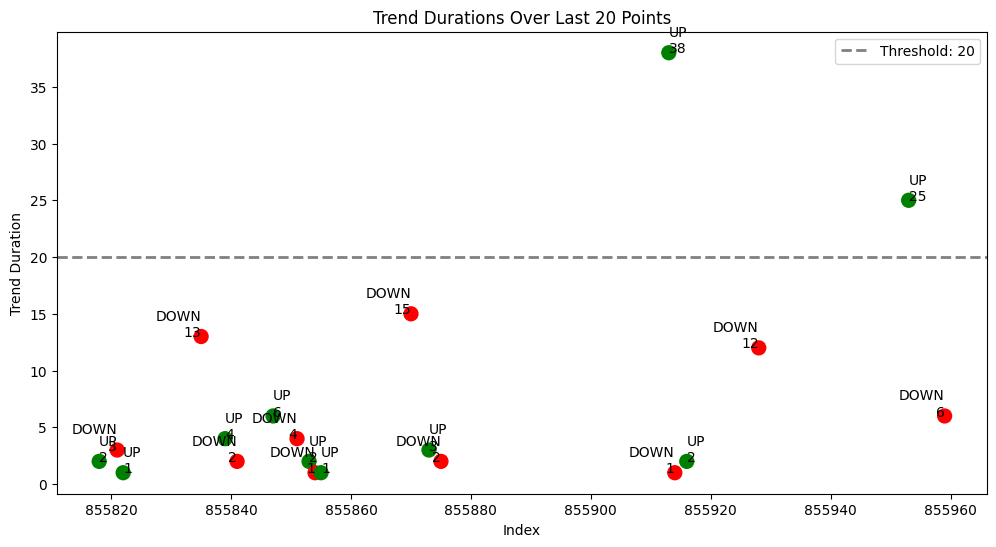

In [1]:
import pyarrow.feather as feather
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the dataset
dataset_file_path = Path('/allah/freqtrade/user_data/data/binance/futures/ETH_USDT_USDT-3m-futures.feather')
crypto_data_df = feather.read_feather(dataset_file_path)


# Calculate Triple Exponential Moving Average (TEMA) on closing prices
tema_period = 50
crypto_data_df['tema'] = talib.TEMA(crypto_data_df['close'], timeperiod=tema_period)

# Establish the trend direction
trend_conditions = [
    crypto_data_df['tema'] > crypto_data_df['tema'].shift(1),
    crypto_data_df['tema'] < crypto_data_df['tema'].shift(1)
]
trend_choices = ['DOWN', 'UP']
crypto_data_df['trend'] = np.select(trend_conditions, trend_choices, default='STABLE')

# Identify trend change points
crypto_data_df['is_trend_change'] = crypto_data_df['trend'] != crypto_data_df['trend'].shift(1)
crypto_data_df['is_trend_change_point'] = crypto_data_df['is_trend_change'] & (crypto_data_df['trend'] != 'STABLE')

# Create a separate DataFrame for change points to avoid SettingWithCopyWarning
trend_change_points_df = crypto_data_df[crypto_data_df['is_trend_change_point']].copy()
trend_change_points_df['trend_duration'] = trend_change_points_df.index.to_series().diff().fillna(0)

# Format data for plottingz
trend_change_points_df = trend_change_points_df.round({'tema': 2, 'volume': 2})
if 'date' in trend_change_points_df.columns:
    trend_change_points_df['date'] = trend_change_points_df['date'].dt.strftime('%Y-%m-%d %H:%M')

# Prepare for visualization
plot_trend_change_points_df = trend_change_points_df.copy()
plot_trend_change_points_df['previous_trend'] = plot_trend_change_points_df['trend'].shift(1)
plot_trend_change_points_df.dropna(subset=['trend_duration'], inplace=True)

# Define parameters for the plot
plot_window_size = 20
plot_trend_change_points_df = plot_trend_change_points_df.tail(plot_window_size)

# Create the scatter plot
plt.figure(figsize=(12, 6))
trend_colors = {'UP': 'red', 'DOWN': 'green', 'STABLE': 'blue'}
plt.scatter(plot_trend_change_points_df.index, plot_trend_change_points_df['trend_duration'], 
            c=plot_trend_change_points_df['previous_trend'].map(trend_colors), 
            marker='o', s=100)

# Additional plot formatting
plt.axhline(y=20, color='gray', linestyle='--', linewidth=2, label='Threshold: 20')
plt.xlabel('Index')
plt.ylabel('Trend Duration')
plt.title(f'Trend Durations Over Last {plot_window_size} Points')

# Annotate points
for idx, row in plot_trend_change_points_df.iterrows():
    alignment = 'right' if row['trend'] == 'DOWN' else 'left'
    plt.text(idx, row['trend_duration'], f"{row['trend']}\n{int(row['trend_duration'])}", ha=alignment)

plt.legend()
plt.show()


In [ ]:
import feather
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
dataset_path = '/allah/freqtrade/user_data/data/binance/futures/ETH_USDT_USDT-1m-futures.feather'
dataframe = feather.read_dataframe(dataset_path)

# Calculate Triple Exponential Moving Average (TEMA) on closing prices
tema_period = 50
dataframe['tema'] = talib.TEMA(dataframe['close'], timeperiod=tema_period)

# Establish the trend direction
conditions = [
    dataframe['tema'] > dataframe['tema'].shift(1),
    dataframe['tema'] < dataframe['tema'].shift(1)
]
choices = ['DOWN', 'UP']
dataframe['trend'] = np.select(conditions, choices, default='STABLE')

# Identify trend change points
dataframe['trend_change'] = dataframe['trend'] != dataframe['trend'].shift(1)
dataframe['trend_change_point'] = dataframe['trend_change'] & (dataframe['trend'] != 'STABLE')

# Create a separate DataFrame for change points to avoid SettingWithCopyWarning
change_points = dataframe[dataframe['trend_change_point']].copy()
change_points['duration'] = change_points.index.to_series().diff().fillna(0)

# Format data for plotting (this step is kept for possible later usage)
change_points = change_points.round({'tema': 2, 'volume': 2})
if 'date' in change_points.columns:
    change_points['date'] = change_points['date'].dt.strftime('%Y-%m-%d %H:%M')

# Calculate signed durations based on trend
change_points['signed_duration'] = change_points.apply(lambda row: row['duration'] if row['trend'] == 'UP' else -row['duration'], axis=1)

# Extracting the signed durations list
duration_list = change_points['signed_duration'].tolist()

# Optionally, print or use this list
print(duration_list)

duration_data = pd.DataFrame(duration_list, columns=['duration'])


In [ ]:
import numpy as np
import os
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import TensorBoard

# Load and prepare the duration data
# Assuming duration_data is already loaded and available as a pandas DataFrame
data_values = duration_data.values.reshape(-1, 1)  # No rescaling applied

# Function to create dataset suitable for multi-class classification
def create_dataset(data, step_size, prediction_window):
    X, y = [], []
    for i in range(len(data) - step_size - prediction_window):
        X.append(data[i:(i + step_size), 0])
        future_segment = data[i + step_size:i + step_size + prediction_window, 0]
        if np.any(future_segment > 20):
            label = 0  # Values greater than 20
        elif np.any(future_segment < -20):
            label = 1  # Values less than -20
        else:
            label = 2  # Neither condition met
        y.append(label)
    return np.array(X), np.array(y)

# Define parameters
step_size = 20
prediction_window = 4  # Looking ahead 4 steps
X, y = create_dataset(data_values, step_size, prediction_window)

# Split the data into training and validation sets
split_ratio = 0.8
split = int(X.shape[0] * split_ratio)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], step_size, 1)
X_val = X_val.reshape(X_val.shape[0], step_size, 1)

# Setup TensorBoard for monitoring
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Construct the LSTM model for multi-class classification with dropout
model = Sequential([
    LSTM(50, input_shape=(step_size, 1), return_sequences=True),
    Dropout(0.2),  # Dropout added after first LSTM layer
    LSTM(50),
    Dropout(0.2),  # Dropout added after second LSTM layer
    Dense(3, activation='softmax')
])

# Compile the model for a multi-class classification problem
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

# Function to predict the class of large changes
def predict_change_category(data):
    last_sequence = data[-step_size:].reshape(1, step_size, 1)  # Adjust the reshaping here for prediction
    predicted_class = model.predict(last_sequence).argmax()
    return predicted_class

# Example: predict the class for the next values
change_category = predict_change_category(data_values)
categories = ['Greater than 20', 'Less than -20', 'Neither']
print("Predicted category for the next values:", categories[change_category])
